In [1]:
import pickle
address = "/media/ictd/New Volume/Entropy/All_Aatif/Aatif_0"

with open(address + '/instance_predicted.pickle', 'rb') as handle:
    instances_predicted = pickle.load(handle)
    instances_predicted = instances_predicted.T
    
segments = instances_predicted.max()

In [2]:
import numpy as np
np.where(instances_predicted[instances_predicted==45]==45)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [3]:
instances_predicted.shape

(4096, 4096)

In [4]:
min_i = {}
min_j = {}
max_i = {}
max_j = {}
printcounter = 0
for i in range(instances_predicted.shape[0]):
    if printcounter == 1000:
        print(i)
        printcounter=0
    printcounter+=1
    for j in range(instances_predicted.shape[0]):
        val = instances_predicted[i][j]
        if val not in min_i:
            min_i[val] = i
        if val not in max_i:
            max_i[val] = i
        if val not in min_j:
            min_j[val] = j
        if val not in max_j:
            max_j[val] = j
        min_i[val] = min(i, min_i[val])
        min_j[val] = min(j, min_j[val])
        max_i[val] = max(i, max_i[val])
        max_j[val] = max(j, max_j[val])     

1000
2000
3000
4000


In [5]:
index = 130
true_y, true_x = np.where(instances_predicted==index)
min_x, max_x = np.min(true_x), np.max(true_x)
min_y, max_y = np.min(true_y), np.max(true_y)
print(min_x, min_y, max_x, max_y)

0 3694 28 3711


In [6]:
print(min_j[index], min_i[index], max_j[index], max_i[index])

0 3694 28 3711


In [7]:

address


'/media/ictd/New Volume/Entropy/All_Aatif/Aatif_0'

In [8]:
import PIL
from PIL import Image
PIL.Image.MAX_IMAGE_PIXELS = 2000000000
input_image_path = address + '/field.tif'
image = Image.open(input_image_path)
with open(address + '/instance_predicted.pickle', 'rb') as handle:
    instances_predicted = pickle.load(handle)
    instances_predicted = instances_predicted.T
segments = instances_predicted.max()
print("Max segments are ", segments)

original_image = image
original_image = original_image.crop((0,0,) + instances_predicted.shape)

#original_image = original_image.transpose(PIL.Image.ROTATE_90)

# %%
(0,0) + instances_predicted.shape

# %%
def crop_image_by_mask(image, index):
    #mask = np.array(mask, dtype=bool)

    # Find the coordinates of where the mask is True
    #true_y, true_x = np.where(instances_predicted==index)

    # Find the bounding box of the True values in the mask
    #if true_x.size > 0 and true_y.size > 0:
    #min_x, max_x = np.min(true_x), np.max(true_x)
    #min_y, max_y = np.min(true_y), np.max(true_y)
    min_x, min_y, max_x, max_y = min_j[index], min_i[index], max_j[index], max_i[index]
    # Crop the image using the bounding box
    cropped_image = image.crop((min_x, min_y, max_x + 1, max_y + 1))

    # Crop the mask as well
    cropped_mask = instances_predicted[min_y:max_y + 1, min_x:max_x + 1]
    cropped_mask = cropped_mask==index

    # Convert the cropped image to RGBA (if not already)
    cropped_image = cropped_image.convert("RGBA")

    # Get pixel data
    pixels = np.array(cropped_image)

    # Set pixels where the mask is False to transparent
    pixels[~cropped_mask] = [0, 0, 0, 0]  # Set to transparent

    # Convert back to an image
    masked_image = Image.fromarray(pixels)

    return masked_image, cropped_mask
    #else:
        # If no true values in mask, return the original image or handle as needed
    #    return image, instances_predicted==index

# %%
from skimage import data
from skimage.filters.rank import entropy
from skimage.morphology import disk, ball
import multiprocessing as mp
from skimage.restoration import (
    denoise_tv_chambolle,
    denoise_bilateral,
    denoise_wavelet,
    estimate_sigma,
)

vals = []

def get_entropy(img, mask):
    ent = entropy(np.asarray(img.convert('L')).copy(), disk(5), mask=mask)
    ent = ent[ent>5.2]
    ent = sum(ent)/(sum(sum(mask)))
    return ent

def get_entropy_plantation(img, mask):
    ent = entropy(np.asarray(img.convert('L')).copy(), disk(30), mask=mask)
    ent = ent[ent>0]
    ent = sum(ent)/(sum(sum(mask)))
    return ent

def get_entropy_denoise(img, mask, index):
    img,mask = crop_image_by_mask(original_image, instances_predicted.T==i)
    img = denoise_tv_chambolle(np.asarray(img), channel_axis=-1, weight=0.1)
    ent = entropy(np.asarray(Image.fromarray((img * 255).astype(np.uint8)).convert('L')).copy(), disk(5), mask=mask)
    ent = sum(sum(ent))/(sum(sum(instances_predicted.T==index)))
    return ent

def map_entropy(index):
    img, mask = crop_image_by_mask(original_image, index)
    ent = get_entropy(img, mask)
    color_map = 0
    
    if sum(sum(mask)) > 300000:
        color_map = 0 
    elif ent < 1:# or ent > 5:
        color_map = 1
    else:
        ent_plantation = get_entropy_plantation(img, mask)
        if ent_plantation < 8.5:
            color_map = 1
    return (ent, index, color_map)

def process_in_chunks(number, chunk_size):
    total_chunks = (number + chunk_size - 1) // chunk_size  # Round up to the next whole number
    results = []
    for i in range(total_chunks):
        start = i * chunk_size
        if start==0:
            start+=1
        end = min(start + chunk_size, number)  # Make sure not to exceed the number
        print(f"Processing chunk: {start} to {end - 1}")
        with mp.Pool(16) as p:
            results += p.map(map_entropy,list(range(start,end)))
    return results

results = process_in_chunks(segments+1, 12000)

Max segments are  30663
Processing chunk: 1 to 12000
Processing chunk: 12000 to 23999
Processing chunk: 24000 to 30663


In [9]:
vals = [i[0] for i in results]
color_dict = {i[1]:i[2] for i in results}
color_dict[0] = 0
def color(ind):
    label = color_dict.get(ind)
    if label==1:
        label = ind
    return label
instances_predicted = np.vectorize(color)(instances_predicted)


# %%
from osgeo import gdal, ogr, osr

ds = gdal.Open(address + "/field.tif")

band = ds.GetRasterBand(1)
arr = band.ReadAsArray()
[rows, cols] = arr.shape
arr_min = arr.min()
arr_max = arr.max()

driver = gdal.GetDriverByName("GTiff")

outdata = driver.Create(address + "/out.tif", cols, rows, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(instances_predicted)
#outdata.GetRasterBand(1).SetNoDataValue(10000)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None

from samgeo.common import raster_to_shp
raster_to_shp(tiff_path=address + "/out.tif", output=address + "/out.shp")

import zipfile
zip = zipfile.ZipFile(address + "/stuff.zip", "w", zipfile.ZIP_DEFLATED)
zip.write(address + "/out.shp")
zip.write(address + "/out.cpg")
zip.write(address + "/out.dbf")
zip.write(address + "/out.prj")
zip.write(address + "/out.shx")

zip.close()

ModuleNotFoundError: No module named '_gdal'

In [23]:
ds = gdal.Open(address + "/field.tif")
ds.GetGeoTransform()

(8560045.39170133,
 1.1943449676074878,
 0.0,
 1928027.7862462439,
 0.0,
 -1.1943424823782829)

In [27]:
new_geotransform

(17.061865911836698,
 -1.0256784802704531e-05,
 0,
 77.08005866956132,
 0,
 -1.073399429853012e-05)

In [130]:
import PIL
from PIL import Image
PIL.Image.MAX_IMAGE_PIXELS = 2000000000
input_image_path = address + '/field.tif'
image = Image.open(input_image_path)
with open(address + '/instance_predicted.pickle', 'rb') as handle:
    instances_predicted = pickle.load(handle)
    instances_predicted = instances_predicted.T

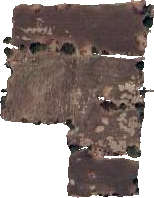

In [116]:
img, mask = crop_image_by_mask(original_image, 262)
img

In [131]:

img, mask = crop_image_by_mask(original_image, 635)
def get_entropy(img, mask):
    ent = entropy(np.asarray(img.convert('L')).copy(), disk(30), mask=mask)
    ent = ent[ent>0]
    ent = sum(ent)/(sum(sum(mask)))
    return ent

sum(sum(mask)), get_entropy(img, mask)

(6877, 7.5610277581145615)

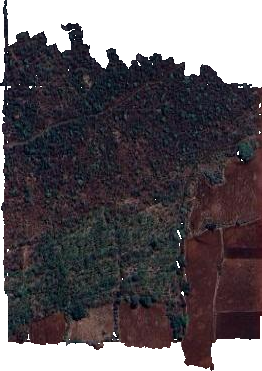

In [146]:
ind = 64647
img, mask = crop_image_by_mask(original_image, ind)
img

In [147]:
sum(sum(mask)), get_entropy(img, mask)

(74153, 7.0379306095841665)

In [26]:
def get_xyz_dict(free_only=True):
    """Returns a dictionary of xyz services.

    Args:
        free_only (bool, optional): Whether to return only free xyz tile services that do not require an access token. Defaults to True.

    Returns:
        dict: A dictionary of xyz services.
    """
    import collections
    import xyzservices.providers as xyz

    def _unpack_sub_parameters(var, param):
        temp = var
        for sub_param in param.split("."):
            temp = getattr(temp, sub_param)
        return temp

    xyz_dict = {}
    for item in xyz.values():
        try:
            name = item["name"]
            tile = _unpack_sub_parameters(xyz, name)
            if _unpack_sub_parameters(xyz, name).requires_token():
                if free_only:
                    pass
                else:
                    xyz_dict[name] = tile
            else:
                xyz_dict[name] = tile

        except Exception:
            for sub_item in item:
                name = item[sub_item]["name"]
                tile = _unpack_sub_parameters(xyz, name)
                if _unpack_sub_parameters(xyz, name).requires_token():
                    if free_only:
                        pass
                    else:
                        xyz_dict[name] = tile
                else:
                    xyz_dict[name] = tile

    xyz_dict = collections.OrderedDict(sorted(xyz_dict.items()))
    return xyz_dict

def get_basemaps(free_only=True):
    """Returns a dictionary of xyz basemaps.

    Args:
        free_only (bool, optional): Whether to return only free xyz tile services that do not require an access token. Defaults to True.

    Returns:
        dict: A dictionary of xyz basemaps.
    """

    basemaps = {}
    xyz_dict = get_xyz_dict(free_only=free_only)
    for item in xyz_dict:
        name = xyz_dict[item].name
        url = xyz_dict[item].build_url()
        basemaps[name] = url

    return basemaps

def tms_to_geotiff(
    output,
    bbox,
    zoom=None,
    resolution=None,
    source="OpenStreetMap",
    crs="EPSG:3857",
    to_cog=False,
    return_image=False,
    overwrite=False,
    quiet=False,
    **kwargs,
):
    """Download TMS tiles and convert them to a GeoTIFF. The source is adapted from https://github.com/gumblex/tms2geotiff.
        Credits to the GitHub user @gumblex.

    Args:
        output (str): The output GeoTIFF file.
        bbox (list): The bounding box [minx, miny, maxx, maxy], e.g., [-122.5216, 37.733, -122.3661, 37.8095]
        zoom (int, optional): The map zoom level. Defaults to None.
        resolution (float, optional): The resolution in meters. Defaults to None.
        source (str, optional): The tile source. It can be one of the following: "OPENSTREETMAP", "ROADMAP",
            "SATELLITE", "TERRAIN", "HYBRID", or an HTTP URL. Defaults to "OpenStreetMap".
        crs (str, optional): The output CRS. Defaults to "EPSG:3857".
        to_cog (bool, optional): Convert to Cloud Optimized GeoTIFF. Defaults to False.
        return_image (bool, optional): Return the image as PIL.Image. Defaults to False.
        overwrite (bool, optional): Overwrite the output file if it already exists. Defaults to False.
        quiet (bool, optional): Suppress output. Defaults to False.
        **kwargs: Additional arguments to pass to gdal.GetDriverByName("GTiff").Create().

    """

    import os
    import io
    import math
    import itertools
    import concurrent.futures

    import numpy
    from PIL import Image

    try:
        from osgeo import gdal, osr
    except ImportError:
        raise ImportError("GDAL is not installed. Install it with pip install GDAL")

    try:
        import httpx

        SESSION = httpx.Client()
    except ImportError:
        import requests

        SESSION = requests.Session()

    if not overwrite and os.path.exists(output):
        print(
            f"The output file {output} already exists. Use `overwrite=True` to overwrite it."
        )
        return

    xyz_tiles = {
        "OPENSTREETMAP": "https://tile.openstreetmap.org/{z}/{x}/{y}.png",
        "ROADMAP": "https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}",
        "SATELLITE": "https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
        "TERRAIN": "https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}",
        "HYBRID": "https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}",
    }

    basemaps = get_basemaps()

    if isinstance(source, str):
        if source.upper() in xyz_tiles:
            source = xyz_tiles[source.upper()]
        elif source in basemaps:
            source = basemaps[source]
        elif source.startswith("http"):
            pass
    else:
        raise ValueError(
            'source must be one of "OpenStreetMap", "ROADMAP", "SATELLITE", "TERRAIN", "HYBRID", or a URL'
        )

    def resolution_to_zoom_level(resolution):
        """
        Convert map resolution in meters to zoom level for Web Mercator (EPSG:3857) tiles.
        """
        # Web Mercator tile size in meters at zoom level 0
        initial_resolution = 156543.03392804097

        # Calculate the zoom level
        zoom_level = math.log2(initial_resolution / resolution)

        return int(zoom_level)

    if isinstance(bbox, list) and len(bbox) == 4:
        west, south, east, north = bbox
    else:
        raise ValueError(
            "bbox must be a list of 4 coordinates in the format of [xmin, ymin, xmax, ymax]"
        )

    if zoom is None and resolution is None:
        raise ValueError("Either zoom or resolution must be provided")
    elif zoom is not None and resolution is not None:
        raise ValueError("Only one of zoom or resolution can be provided")

    if resolution is not None:
        zoom = resolution_to_zoom_level(resolution)

    EARTH_EQUATORIAL_RADIUS = 6378137.0

    Image.MAX_IMAGE_PIXELS = None

    gdal.UseExceptions()
    web_mercator = osr.SpatialReference()
    web_mercator.ImportFromEPSG(3857)

    WKT_3857 = web_mercator.ExportToWkt()

    def from4326_to3857(lat, lon):
        xtile = math.radians(lon) * EARTH_EQUATORIAL_RADIUS
        ytile = (
            math.log(math.tan(math.radians(45 + lat / 2.0))) * EARTH_EQUATORIAL_RADIUS
        )
        return (xtile, ytile)

    def deg2num(lat, lon, zoom):
        lat_r = math.radians(lat)
        n = 2**zoom
        xtile = (lon + 180) / 360 * n
        ytile = (1 - math.log(math.tan(lat_r) + 1 / math.cos(lat_r)) / math.pi) / 2 * n
        return (xtile, ytile)

    def is_empty(im):
        extrema = im.getextrema()
        if len(extrema) >= 3:
            if len(extrema) > 3 and extrema[-1] == (0, 0):
                return True
            for ext in extrema[:3]:
                if ext != (0, 0):
                    return False
            return True
        else:
            return extrema[0] == (0, 0)

    def paste_tile(bigim, base_size, tile, corner_xy, bbox):
        if tile is None:
            return bigim
        im = Image.open(io.BytesIO(tile))
        mode = "RGB" if im.mode == "RGB" else "RGBA"
        size = im.size
        if bigim is None:
            base_size[0] = size[0]
            base_size[1] = size[1]
            newim = Image.new(
                mode, (size[0] * (bbox[2] - bbox[0]), size[1] * (bbox[3] - bbox[1]))
            )
        else:
            newim = bigim

        dx = abs(corner_xy[0] - bbox[0])
        dy = abs(corner_xy[1] - bbox[1])
        xy0 = (size[0] * dx, size[1] * dy)
        if mode == "RGB":
            newim.paste(im, xy0)
        else:
            if im.mode != mode:
                im = im.convert(mode)
            if not is_empty(im):
                newim.paste(im, xy0)
        im.close()
        return newim

    def finish_picture(bigim, base_size, bbox, x0, y0, x1, y1):
        xfrac = x0 - bbox[0]
        yfrac = y0 - bbox[1]
        x2 = round(base_size[0] * xfrac)
        y2 = round(base_size[1] * yfrac)
        imgw = round(base_size[0] * (x1 - x0))
        imgh = round(base_size[1] * (y1 - y0))
        retim = bigim.crop((x2, y2, x2 + imgw, y2 + imgh))
        if retim.mode == "RGBA" and retim.getextrema()[3] == (255, 255):
            retim = retim.convert("RGB")
        bigim.close()
        return retim

    def get_tile(url):
        retry = 3
        while 1:
            try:
                r = SESSION.get(url, timeout=60)
                break
            except Exception:
                retry -= 1
                if not retry:
                    raise
        if r.status_code == 404:
            return None
        elif not r.content:
            return None
        r.raise_for_status()
        return r.content

    def draw_tile(
        source, lat0, lon0, lat1, lon1, zoom, filename, quiet=False, **kwargs
    ):
        x0, y0 = deg2num(lat0, lon0, zoom)
        x1, y1 = deg2num(lat1, lon1, zoom)
        x0, x1 = sorted([x0, x1])
        y0, y1 = sorted([y0, y1])
        corners = tuple(
            itertools.product(
                range(math.floor(x0), math.ceil(x1)),
                range(math.floor(y0), math.ceil(y1)),
            )
        )
        totalnum = len(corners)
        futures = []
        with concurrent.futures.ThreadPoolExecutor(5) as executor:
            for x, y in corners:
                futures.append(
                    executor.submit(get_tile, source.format(z=zoom, x=x, y=y))
                )
            bbox = (math.floor(x0), math.floor(y0), math.ceil(x1), math.ceil(y1))
            bigim = None
            base_size = [256, 256]
            for k, (fut, corner_xy) in enumerate(zip(futures, corners), 1):
                bigim = paste_tile(bigim, base_size, fut.result(), corner_xy, bbox)
                if not quiet:
                    print(
                        f"Downloaded image {str(k).zfill(len(str(totalnum)))}/{totalnum}"
                    )

        if not quiet:
            print("Saving GeoTIFF. Please wait...")
        img = finish_picture(bigim, base_size, bbox, x0, y0, x1, y1)
        imgbands = len(img.getbands())
        driver = gdal.GetDriverByName("GTiff")

        if "options" not in kwargs:
            kwargs["options"] = [
                "COMPRESS=DEFLATE",
                "PREDICTOR=2",
                "ZLEVEL=9",
                "TILED=YES",
            ]

        gtiff = driver.Create(
            filename,
            img.size[0],
            img.size[1],
            imgbands,
            gdal.GDT_Byte,
            **kwargs,
        )
        xp0, yp0 = from4326_to3857(lat0, lon0)
        xp1, yp1 = from4326_to3857(lat1, lon1)
        pwidth = abs(xp1 - xp0) / img.size[0]
        pheight = abs(yp1 - yp0) / img.size[1]
        gtiff.SetGeoTransform((min(xp0, xp1), pwidth, 0, max(yp0, yp1), 0, -pheight))
        gtiff.SetProjection(WKT_3857)
        for band in range(imgbands):
            array = numpy.array(img.getdata(band), dtype="u8")
            array = array.reshape((img.size[1], img.size[0]))
            band = gtiff.GetRasterBand(band + 1)
            band.WriteArray(array)
        gtiff.FlushCache()

        if not quiet:
            print(f"Image saved to {filename}")
        return img

    try:
        image = draw_tile(
            source, south, west, north, east, zoom, output, quiet, **kwargs
        )
        if return_image:
            return image
        if crs.upper() != "EPSG:3857":
            reproject(output, output, crs, to_cog=to_cog)
        elif to_cog:
            image_to_cog(output, output)
    except Exception as e:
        raise Exception(e)

In [27]:
import os
address = "temp2"
output_dir = address
os.makedirs(output_dir, exist_ok=True)
bbox = [84.91588436852803, 24.417834295365942,  84.93083003731255, 24.406562870674097]
tms_to_geotiff(output=address + "/field_1.tif", bbox=bbox, zoom=18, source='Satellite', overwrite=True)

Downloaded image 001/120
Downloaded image 002/120
Downloaded image 003/120
Downloaded image 004/120
Downloaded image 005/120
Downloaded image 006/120
Downloaded image 007/120
Downloaded image 008/120
Downloaded image 009/120
Downloaded image 010/120
Downloaded image 011/120
Downloaded image 012/120
Downloaded image 013/120
Downloaded image 014/120
Downloaded image 015/120
Downloaded image 016/120
Downloaded image 017/120
Downloaded image 018/120
Downloaded image 019/120
Downloaded image 020/120
Downloaded image 021/120
Downloaded image 022/120
Downloaded image 023/120
Downloaded image 024/120
Downloaded image 025/120
Downloaded image 026/120
Downloaded image 027/120
Downloaded image 028/120
Downloaded image 029/120
Downloaded image 030/120
Downloaded image 031/120
Downloaded image 032/120
Downloaded image 033/120
Downloaded image 034/120
Downloaded image 035/120
Downloaded image 036/120
Downloaded image 037/120
Downloaded image 038/120
Downloaded image 039/120
Downloaded image 040/120


In [ ]:
vals = [i[0] for i in results]
color_dict = {i[1]:i[2] for i in results}
color_dict[0] = 0
def color(ind):
    label = color_dict.get(ind)
    if label==1:
        label = ind
    return label
instances_predicted = np.vectorize(color)(instances_predicted)


# %%
from osgeo import gdal, ogr, osr

ds = gdal.Open(address + "/field.tif")

band = ds.GetRasterBand(1)
arr = band.ReadAsArray()
[rows, cols] = arr.shape
arr_min = arr.min()
arr_max = arr.max()

driver = gdal.GetDriverByName("GTiff")

outdata = driver.Create(address + "/out.tif", cols, rows, 1, gdal.GDT_UInt16)

src_proj = osr.SpatialReference()
src_proj.ImportFromWkt(ds.GetProjection())

dst_proj = osr.SpatialReference()
dst_proj.ImportFromEPSG(4326)
transform = osr.CoordinateTransformation(src_proj, dst_proj)
src_geotransform = ds.GetGeoTransform()

width = ds.RasterXSize
height = ds.RasterYSize
    
    # Transform the corner coordinates to the new projection
min_x, min_y, _ = transform.TransformPoint(src_geotransform[0], src_geotransform[3])
max_x, max_y, _ = transform.TransformPoint(
        src_geotransform[0] + src_geotransform[1] * width, 
        src_geotransform[3] + src_geotransform[5] * height
    )
    
    # Compute the new geotransform for the EPSG:4326 projection
new_geotransform = (
        min_x,  # top left x (longitude)
        (max_x - min_x) / width,  # pixel width (x scale)
        0,  # rotation
        max_y,  # top left y (latitude)
        0,  # rotation
        (min_y - max_y) / height  # pixel height (y scale)
    )

outdata.SetProjection(dst_proj.ExportToWkt())##sets same projection as input
outdata.SetGeoTransform(new_geotransform)##sets same geotransform as input

outdata.GetRasterBand(1).WriteArray(instances_predicted)
#outdata.GetRasterBand(1).SetNoDataValue(10000)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None

from samgeo.common import raster_to_shp
raster_to_shp(tiff_path=address + "/out.tif", output=address + "/out.shp")

import zipfile
zip = zipfile.ZipFile(address + "/stuff.zip", "w", zipfile.ZIP_DEFLATED)
zip.write(address + "/out.shp")
zip.write(address + "/out.cpg")
zip.write(address + "/out.dbf")
zip.write(address + "/out.prj")
zip.write(address + "/out.shx")

zip.close()